# Project: Topic Classification

In this project, I work with text data from newsgroup postings on a variety of topics. I'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. This makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB\
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If we remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[(num_test//2):], newsgroups_test.target[(num_test//2):]
dev_data, dev_labels = newsgroups_test.data[:num_test//2], newsgroups_test.target[:num_test//2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### (1) For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):
    """This module prints the specified number of messages and their labels
    with a default of 5 messages.
    """
    
    for i in range(num_examples):
        print("The label for this message is {}".format(categories[train_labels[i]]))
        print(" ")
        print(train_data[i])
        print("--------------------------------------")
        
P1(5)

The label for this message is talk.religion.misc
 
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
--------------------------------------
The label for this message is sci.space
 


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes l

### (2) Use CountVectorizer to turn the raw training text into feature vectors. I will use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. Write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? 

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? 

In [4]:
def P2():
    print('a.')
    a = CountVectorizer()
    a_feat = a.fit_transform(train_data)
    print('Size of Vocab: {}'.format(a_feat.shape[1]))
    print('Average # of Non-Zero features per example: {}'.format((a_feat.nnz)/(a_feat.shape[0])))
    print('Fraction of entries in matrix that are non-zero: {} '.format(a_feat.nnz/(a_feat.shape[0] * a_feat.shape[1])))
    
    print('\nb.')
    print('0th feature in alphabetical order: {}'.format(a.get_feature_names()[0]))
    print('Last feature in alphabetical order: {}'.format(a.get_feature_names()[-1]))
    
    print('\nc.')
    c = CountVectorizer(vocabulary=["atheism","graphics","space","religion"])
    c_feat = c.fit_transform(train_data)
    print('Shape {}'.format(c_feat.shape))
    print('Average # non-zero features per example: {}'.format(c_feat.nnz/c_feat.shape[0]))
    
    print('\nd.')
    d = CountVectorizer(ngram_range= (2,3), analyzer='char')
    d_feat = d.fit_transform(train_data)
    print('Vocab size: {}'.format(d_feat.shape[1]))
    
    print('\ne.')
    e = CountVectorizer(min_df=10)
    e_feat = e.fit_transform(train_data)
    print('Vocab size appearing in more than 10 documents: {}'.format(e_feat.shape[1]))
    
    print('\nf.')
    f = CountVectorizer()
    f_dev_feat = f.fit_transform(dev_data)
    train_voc = a.get_feature_names()
    dev_voc = f.get_feature_names()
    print('Training set has {} features whereas dev set has {} features'.format(len(train_voc), len(dev_voc)))
    dev_unique = np.setdiff1d(dev_voc, train_voc).shape[0]
    print('Unique vocab in dev data but not in training data is {}'.format(dev_unique))
    print('Therefore, there is a {:.2f}% difference from dev data missing from the training vocabulary'.format((dev_unique/len(dev_voc))*100))
    
P2()

a.
Size of Vocab: 26879
Average # of Non-Zero features per example: 96.70599803343165
Fraction of entries in matrix that are non-zero: 0.0035978272269590263 

b.
0th feature in alphabetical order: 00
Last feature in alphabetical order: zyxel

c.
Shape (2034, 4)
Average # non-zero features per example: 0.26843657817109146

d.
Vocab size: 35478

e.
Vocab size appearing in more than 10 documents: 3064

f.
Training set has 26879 features whereas dev set has 16246 features
Unique vocab in dev data but not in training data is 4027
Therefore, there is a 24.79% difference from dev data missing from the training vocabulary


### (3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

In [5]:
def P3():
    p3 = CountVectorizer()
    p3_feat = p3.fit_transform(train_data)
    p3_dev_feat = p3.transform(dev_data)

    knn = KNeighborsClassifier()
    knn.fit(p3_feat, train_labels)
    knn_pred = knn.predict(p3_dev_feat)         
    print ('F1 score using default KNN: {}'.format(metrics.f1_score(knn_pred, dev_labels, average='micro')))

    # Optimize knn's k-value
    n_range = {'n_neighbors': range(1,100)}
    knn_search = GridSearchCV(estimator=knn, param_grid=n_range, scoring='f1_micro')
    knn_search.fit(p3_feat, train_labels)
    print('Best KNN score from 0 to 100 features: {} with {}'.format(knn_search.best_score_,knn_search.best_params_))

    print ('\n')
    # Multinomial Naive Bayes 
    mnb = MultinomialNB()
    mnb.fit(p3_feat, train_labels)
    mnb_pred = mnb.predict(p3_dev_feat)
    print ('F1 score using default MulitnomialNB: {}'.format(metrics.f1_score(mnb_pred,dev_labels, average='micro')))

    # Optimize MultinomialNB alpha
    alphas = {'alpha': [0.0001,0.001,0.01,0.1,1,10]}
    mnb_search = GridSearchCV(estimator = mnb, param_grid=alphas, scoring='f1_micro')
    mnb_search.fit(p3_feat, train_labels)    
    print ('Best MulitnomialNB score: {} with {}'.format(mnb_search.best_score_, mnb_search.best_params_))

    print ('\n')
    # Logistic regression
    lr = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='auto', max_iter=1000)
    lr.fit(p3_feat, train_labels)
    lr_pred = lr.predict(p3_dev_feat)
    print ('F1 score using default Logistic Regression: {}'.format(metrics.f1_score(lr_pred, dev_labels, average='micro')))

    # Optimize log regression parameters
    lr_c = {'C': [0.001,0.01,1.0,1.5,3.0,4.5,10.0,20.0,30.0,100.0,1000.0]}
    lr_search = GridSearchCV(estimator = lr, param_grid=lr_c, scoring='f1_micro')
    lr_search.fit(p3_feat, train_labels)    
    print('Best Logistic Regression score: {} with {}'.format(lr_search.best_score_,lr_search.best_params_))

    # P3c. Output the sum of the squared weight values for each class for each setting of the C parameter
    print ('\n')
    coefficients = []
    c_param = [0.001,0.01,1.0,1.5,3.0,4.5,10.0,20.0,30.0,100.0,1000.0]
    for c in c_param:
        lr = LogisticRegression(C=c, penalty='l2', solver='lbfgs', multi_class='auto', max_iter=1000)
        lr.fit(p3_feat,train_labels)
        lr_pred = lr.predict(p3_dev_feat)
        coefficients.append(lr.coef_)

    print('\nOutput the sum of the squared weight values for each class for each setting of the C parameter: \n')
    for i in range(len(coefficients)):
        coef_sq = np.square(coefficients[i])
        print ('C =', str(c_param[i]), np.sum(np.sum(coef_sq,axis=1)))
P3()

F1 score using default KNN: 0.4230769230769231


C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best KNN score from 0 to 100 features: 0.4444444444444444 with {'n_neighbors': 96}


F1 score using default MulitnomialNB: 0.7810650887573964


C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best MulitnomialNB score: 0.828416912487709 with {'alpha': 0.01}


F1 score using default Logistic Regression: 0.6967455621301775


C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best Logistic Regression score: 0.7463126843657817 with {'C': 1.0}



Output the sum of the squared weight values for each class for each setting of the C parameter: 

C = 0.001 0.46474583392061836
C = 0.01 6.794754406631711
C = 1.0 275.1795717143728
C = 1.5 343.07563152919323
C = 3.0 482.79055747271946
C = 4.5 578.7218060945434
C = 10.0 798.8307860144705
C = 20.0 1024.4873161904093
C = 30.0 1171.7827721199158
C = 100.0 1678.9792111965469
C = 1000.0 2954.770654328501


#### ANSWER:

#### a. Why doesn't nearest neighbors work well for this problem?

Nearest neighbor classifers do not work well with a large amount of features. There isn't a set amount of what defines a "large" amount, but the theory behind knn classifier is the distance between the nearest neighbor. Therefore the more features involved, the farther away the nearest neighbor may appear which makes it harder for the model to find the best features for prediction. 

#### b. Any ideas why logistic regression doesn't work as well as Naive Bayes?
It seems like logistic regression does not work because there are more features than the training examples and therefore the logistic regression model is overfitting. Naive Bayes works better in this case since it assumes independence between features and thus does not make false correlations between features for prediction.

#### c. Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

The output of sum of squared weights for each class for each setting of C is listed above. As C gets larger in value, the size of the parameters of the logistic regression model increases in magnitude to adjust to the training data. Smaller values of C is associated with a smaller magnitude of errors.

### (4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [6]:
def P4():
    
    def p4model(model):
        """Runs basic Logistic Regression with the best C value from P3."""
        # Initialize given model with features, dev features, and feature names
        p4 = model
        p4_feat = p4.fit_transform(train_data)
        p4_feat_names = p4.get_feature_names()

        # best C value from P3 is C = 1.0
        p4lr = LogisticRegression(C=1.0) 

        # fit the model to the features.
        p4lr.fit(p4_feat, train_labels)

        # Getting the names/values based off p4lr
        indexes = np.argpartition(np.absolute(p4lr.coef_), -5)[:,-5:].flatten()
        names = [p4_feat_names[index].encode('utf-8') for index in indexes]
        weight = np.transpose(np.take(p4lr.coef_, indexes, axis=1))

        print('Feature: Weight')
        for i in range(len(names)):
            print('{} : {}'.format(names[i], weight[i]))
    print('Unigram Table \n')    
    p4model(CountVectorizer())
    print('\nBigram Table\n')
    p4model(CountVectorizer(ngram_range=(2, 2), analyzer='word'))

P4()

Unigram Table 



C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Feature: Weight
b'religion' : [ 0.95354582 -0.61689943 -0.79298467 -0.06441939]
b'bobby' : [ 0.98972142 -0.22073778 -0.34106939 -0.46354848]
b'atheists' : [ 1.0310803  -0.09776789 -0.31899263 -0.83472376]
b'space' : [-1.26037737 -1.31601271  2.1624432  -1.17078722]
b'deletion' : [ 1.1248112  -0.39814768 -0.4201916  -0.39548392]
b'3d' : [-0.35897245  1.12511083 -0.70249868 -0.37845842]
b'file' : [-0.3347297   1.26660805 -0.80689696 -0.6266535 ]
b'space' : [-1.26037737 -1.31601271  2.1624432  -1.17078722]
b'graphics' : [-0.75836884  1.93675677 -1.33652085 -0.76274472]
b'image' : [-0.58294149  1.34686696 -0.82500143 -0.46853152]
b'launch' : [-0.4708434  -0.4655019   0.93665666 -0.33252148]
b'graphics' : [-0.75836884  1.93675677 -1.33652085 -0.76274472]
b'orbit' : [-0.4139613  -0.67168256  1.22504801 -0.62926859]
b'space' : [-1.26037737 -1.31601271  2.1624432  -1.17078722]
b'nasa' : [-0.57257011 -0.48024253  1.01144521 -0.46783605]
b'could' : [ 0.22766947 -0.13027734  0.34356266 -0.9299406

ANSWER: I was surprised that the unigram features do not also appear in the bigram features with the exception of 'space' and 'graphics' although the bigram features could easily be associated with more than one of the unigram features. Bigram features also had 'cheers kent' and 'looking for' appear twice, yet neither of these words appeared in the unigram weights.

### (5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

In [7]:
def empty_preprocessor(s):
    return s

def p5model(model):
    """Runs a basic logistic regression model."""
    p5 = model
    p5_feat = model.fit_transform(train_data)
    p5_dev_feat = p5.transform(dev_data)
    p5lr = LogisticRegression()
    p5lr.fit(p5_feat, train_labels)
    p5_pred = p5lr.predict(p5_dev_feat)
    p5_f1 = metrics.f1_score(p5_pred, dev_labels, average='macro')
    print('Shape: {}'.format(p5_feat.shape))
    print('F1 score: {}'.format(p5_f1))
    return p5_feat.shape[1]

def better_preprocessor(s):
    """ Transforms the strings that are inputted."""
    # Turn everything to lowercase
    s = s.lower()
    
    # replace sequence of numbers
    s = re.sub(r'\d+', ' ', s) 
    
    # remove anything that is not a letter
    s = re.sub("[^a-zA-Z]", " ", s)
    
    # remove words of up to 3 characters
    s = re.sub(r'\b\w{,3}\b', '', s)
    
    # remove words greater than 15 characters
    s = re.sub(r'\b\w{15,}\b', '', s)

    return s

def P5():
    print('Empty preprocessor')
    a = p5model(CountVectorizer(preprocessor=empty_preprocessor))
    
    print('\nImproved preprocessor')
    b = p5model(CountVectorizer(preprocessor=better_preprocessor))
    
    diff = a-b
    print('\nMy new preprocessor reduced the size of the vocabulary by {} words and increased the F1 score'.format(diff))
P5()

Empty preprocessor
Shape: (2034, 33291)
F1 score: 0.6870608946268841

Improved preprocessor
Shape: (2034, 21917)
F1 score: 0.7029983761155641

My new preprocessor reduced the size of the vocabulary by 11374 words and increased the F1 score


### (6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).


L1 Model
Nonzero weights: 1815

L2 Model
Nonzero weights: 107516


C:\Users\Theod\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


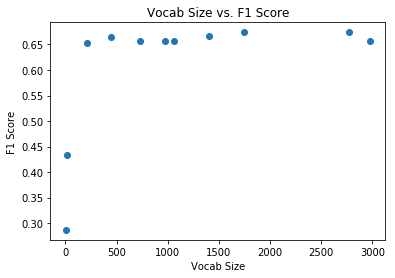

In [8]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    def p6model(model=CountVectorizer(), lr=LogisticRegression()):
        """Model with basic logistic regression."""
        p6 = model
        p6_feat = p6.fit_transform(train_data)
        p6_dev_feat = p6.transform(dev_data)
        p6_feat_name = p6.get_feature_names()
        p6lr = lr
        p6lr.fit(p6_feat, train_labels)
        weight_nonzero = np.argwhere(p6lr.coef_!=0)
        print('Nonzero weights: {}'.format(weight_nonzero.shape[0]))
    
    print('\nL1 Model')
    p6model(lr=LogisticRegression(penalty='l1', tol=0.01))
    print('\nL2 Model')
    p6model(lr=LogisticRegression(penalty='l2', tol=0.01))

    def p6model2(model=CountVectorizer(), c=0.5):
        """Model with basic logistic regression with a set c value."""
        # Original model with l1
        p6 = model
        p6_feat = p6.fit_transform(train_data)
        p6_dev_feat = p6.transform(dev_data)
        p6_feat_name = p6.get_feature_names()
        p6lr = LogisticRegression(penalty='l1', C=c, tol=0.01)
        p6lr.fit(p6_feat, train_labels)

        # remove nonzeros weights
        weight_nonzero = np.argwhere(p6lr.coef_!=0)


        # adding new vocab for second model
        vocab_nonzero = np.unique(weight_nonzero[:,-1])
        new_voc = []
        for i in vocab_nonzero:
            new_voc.append(p6_feat_name[i])

        # second l2 model trained better
        p62 = CountVectorizer(vocabulary=new_voc)
        p6_feat2 = p62.transform(train_data)
        p6_dev_feat2 = p62.transform(dev_data)
        p6_feat_name2 = p62.get_feature_names()
        p6lr2 = LogisticRegression(penalty='l2', C=c, tol=0.01, max_iter=200)
        p6lr2.fit(p6_feat2, train_labels)
        p6_pred2 = p6lr2.predict(p6_dev_feat2)

        # add vocab size with nonzero to list
        vocab_size.append(p6_feat2.shape[1])

        # calculate and appends f1_scores
        f1_scores.append(metrics.f1_score(p6_pred2, dev_labels, average='macro'))

    # Initialize list for function
    vocab_size = []
    f1_scores = []
    cValues = [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.5, 5.0, 10.0]

    for c in cValues:
        p6model2(c=c)

    plt.plot(vocab_size, f1_scores, 'o')
    plt.title('Vocab Size vs. F1 Score')  
    plt.ylabel('F1 Score') 
    plt.xlabel('Vocab Size') 
    plt.show()
P6()

### (7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [9]:
def P7():
    """ Uses TfidfVectorizer to show difference from CountVectorizer."""
    p7 = TfidfVectorizer()
    p7_feat = p7.fit_transform(train_data)
    p7_dev_feat = p7.transform(dev_data)
    p7lr = LogisticRegression(C=100)
    p7lr.fit(p7_feat, train_labels)
    p7_pred = p7lr.predict(p7_dev_feat)
    print ('F1 Score: {}'.format(metrics.f1_score(p7_pred, dev_labels, average='macro')))

    # correct predict proba
    p7_pred_proba = p7lr.predict_proba(p7_dev_feat)
    ans = []
    for i in range(len(p7_pred_proba)):
        ans.append(p7_pred_proba[i, dev_labels[i]])

    # max predict proba
    p7_max_pred_proba = np.amax(p7_pred_proba, axis=1)

    # r_ratio
    r_ratio = p7_max_pred_proba / ans

    top_3_index = np.argpartition(r_ratio, -3)[-3:]
    top_3 = np.take(r_ratio, top_3_index)

    for i in top_3_index:
        print('------------------')
        print('\n{}\n\nPredicted: {} \nActual: {}'.format(dev_data[i],newsgroups_train.target_names[p7_pred[i]], newsgroups_train.target_names[dev_labels[i]]))

P7()

F1 Score: 0.7473913101645842
------------------


The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...


Predicted: talk.religion.misc 
Actual: alt.atheism
------------------

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

Predicted: comp.graphics 
Actual: talk.religion.misc
------------------

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossa

ANSWER: The model predicted computer graphics when computers were mentioned despite the fact that computers were a medium for the actual message which appeared to be religion. Therefore, we can improve the model by adding stopwords for computer terms such as 'e-mail' but retain computer graphic specific words such as 'images'